# PROBLEM OVERVIEW

At Uber accurate prediction for completed trips (particularly during special events) provides a series of important benefits: more efficient driver allocation resulting in a decreased wait time for the riders, budget planning and other related tasks.

In order to reach high accurate predictions of driver demand for ride-sharing, Uber Researchers developed a high-performance model for time series forecasting. They are able to fit (one-shot) a single model with a lot of heterogeneous time series, coming from different locations/cities. This process permits us to extract relevant time patterns. In the end, they were able to forecast demand, generalizing for different locations/cities, outperforming the classical forecasting methods.m

# dataset

Our choice was due to the need for a nested dataset with temporal dependency: we have time series for each US market, 54 in total, a number that grows to 108 if we consider one time series for each type (conventional and organic). This data structure is highlighted as important by Uber Researchers because it permits to our model to discover important invisible relations. Also, the correlation among series brings advantages for our LSTM Autoencoder during the process of feature extraction.

To build our model we utilized the time series of prices at our disposal up to the end of 2017. The first 2 months of 2018 are stored and used as test set. For our analysis, we will take into consideration also all the provided regressors. The observations are shown with a weakly frequency so our purpose is: given a fixed past window (4 weeks) of features, predict the upcoming weakly price.

Due to the absence of exponential growth and trending behavior, we don’t need to scale our price series.`

# Library

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
import random
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K

In [8]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append(f'E:\gitlab\custom-script\script')
from ursar import visual

%reload_ext autoreload

# read dataset

In [2]:
df = pd.read_csv(r'E:\gitlab\machine-learning\dataset/avocado.csv', index_col=0, parse_dates=['Date'])
df.sort_values('Date', inplace=True)

print(df.shape)
df.head()

(18249, 13)


,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
51,2015-01-04,1.75,27365.89,9307.34,3844.81,615.28,13598.46,13061.10,537.36,0.0,organic,2015,Southeast
51,2015-01-04,1.49,17723.17,1189.35,15628.27,0.00,905.55,905.55,0.00,0.0,organic,2015,Chicago
51,2015-01-04,1.68,2896.72,161.68,206.96,0.00,2528.08,2528.08,0.00,0.0,organic,2015,HarrisburgScranton
51,2015-01-04,1.52,54956.80,3013.04,35456.88,1561.70,14925.18,11264.80,3660.38,0.0,conventional,2015,Pittsburgh
51,2015-01-04,1.64,1505.12,1.27,1129.50,0.00,374.35,186.67,187.68,0.0,organic,2015,Boise


# PLOT SERIES FOR SINGLE MARKET OF SELECTED AVOCADO TYPE

In [3]:
def plot_seris(county, typ):
    
    plt.figure(figsize=(9,6))
    reg_train = df[(df['type']==typ)&(df['year']!=2018)].groupby('region')
    p_train = reg_train.get_group(county)[['Date', 'AveragePrice']].reset_index(drop=True)
    plt.plot(range(0,len(p_train)), p_train.AveragePrice.values)
    
    reg_test = df[(df['type']==typ)&(df['year']==2018)].groupby('region')
    p_test = reg_test.get_group(county)[['Date', 'AveragePrice']].reset_index(drop=True)
    plt.plot(range(len(p_train),len(p_train)+len(p_test)),p_test.AveragePrice.values)
    plt.title('AveragePrice'+' '+typ.upper()+' '+county)
    plt.show()

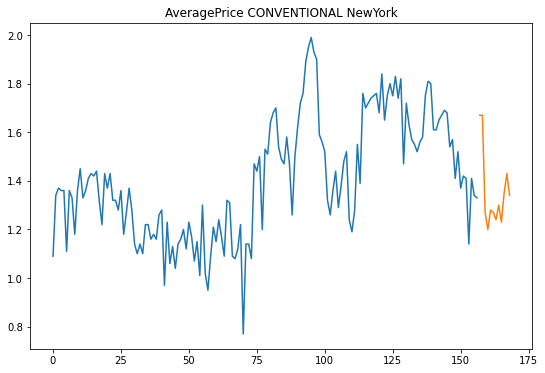

In [4]:
reg_train = plot_seris('NewYork','conventional')

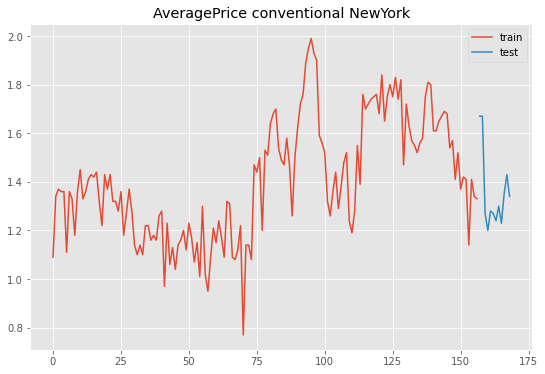

In [14]:
visual.plot_series(df,'type','conventional','year',2018,'region','NewYork','Date', 'AveragePrice')

# CREATE GENERATOR FOR LSTM WINDOWS AND LABELS

In [5]:
sequence_length = 4

def gen_sequence(id_df, seq_length, seq_cols):

    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

def gen_labels(id_df, seq_length, label):

    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]

    return data_matrix[seq_length:num_elements, :]

# CREATE TRAIN/TEST PRICE DATA

In [15]:
X_train_c, X_train_o = [], []
X_test_c, X_test_o = [], []
X_other_train_c, X_other_train_o = [], []
X_other_test_c, X_other_test_o = [], []

for county in df["region"].unique():
    
    for sequence in gen_sequence(df[(df["region"]==county)&(df["type"]=="conventional")&(df["year"]!=2018)],
                                 sequence_length, ['AveragePrice']):
        X_train_c.append(sequence) if county != 'Albany' else X_other_train_c.append(sequence)
        
    for sequence in gen_sequence(df[(df["region"]==county)&(df["type"]=="organic")&(df["year"]!=2018)], 
                                 sequence_length, ['AveragePrice']):
        X_train_o.append(sequence) if county != 'Albany' else X_other_train_o.append(sequence)
        
    for sequence in gen_sequence(df[(df["region"]==county)&(df["type"]=="conventional")&(df["year"]==2018)], 
                                 sequence_length, ['AveragePrice']):
        X_test_c.append(sequence) if county != 'Albany' else X_other_test_c.append(sequence)
        
    for sequence in gen_sequence(df[(df["region"]==county)&(df["type"]=="organic")&(df["year"]==2018)], 
                                 sequence_length, ['AveragePrice']):
        X_test_o.append(sequence) if county != 'Albany' else X_other_test_o.append(sequence)
    
X_train_c, X_train_o = np.asarray(X_train_c), np.asarray(X_train_o)
X_test_c, X_test_o = np.asarray(X_test_c), np.asarray(X_test_o)
X_other_train_c, X_other_train_o = np.asarray(X_other_train_c), np.asarray(X_other_train_o)
X_other_test_c, X_other_test_o = np.asarray(X_other_test_c), np.asarray(X_other_test_o)

# CREATE TRAIN/TEST LABEL

In [16]:
y_train_c, y_train_o = [], []
y_test_c, y_test_o = [], []
y_other_train_c, y_other_train_o = [], []
y_other_test_c, y_other_test_o = [], []

for county in df["region"].unique():
    
    for sequence in gen_labels(df[(df["region"]==county)&(df["type"]=="conventional")&(df["year"]!=2018)], 
                               sequence_length, ['AveragePrice']):
        y_train_c.append(sequence) if county != 'Albany' else y_other_train_c.append(sequence)
        
    for sequence in gen_labels(df[(df["region"]==county)&(df["type"]=="organic")&(df["year"]!=2018)], 
                               sequence_length, ['AveragePrice']):
        y_train_o.append(sequence) if county != 'Albany' else y_other_train_o.append(sequence)
        
    for sequence in gen_labels(df[(df["region"]==county)&(df["type"]=="conventional")&(df["year"]==2018)],
                               sequence_length, ['AveragePrice']):
        y_test_c.append(sequence) if county != 'Albany' else y_other_test_c.append(sequence)
        
    for sequence in gen_labels(df[(df["region"]==county)&(df["type"]=="organic")&(df["year"]==2018)],
                               sequence_length, ['AveragePrice']):
        y_test_o.append(sequence) if county != 'Albany' else y_other_test_o.append(sequence)

y_train_c, y_train_o = np.asarray(y_train_c), np.asarray(y_train_o)
y_test_c, y_test_o = np.asarray(y_test_c), np.asarray(y_test_o)
y_other_train_c, y_other_train_o = np.asarray(y_other_train_c), np.asarray(y_other_train_o)
y_other_test_c, y_other_test_o = np.asarray(y_other_test_c), np.asarray(y_other_test_o)

# CONCATENATE TRAIN/TEST DATA AND LABEL

In [17]:
X = np.concatenate([X_train_c,X_train_o,X_test_c,X_test_o],axis=0)
y = np.concatenate([y_train_c,y_train_o,y_test_c,y_test_o],axis=0)

print(X.shape,y.shape)

(17063, 4, 1) (17063, 1)


# CREATE TRAIN/TEST EXTERNAL FEATURES

In [18]:
col = ['Total Volume','4046','4225','4770','Total Bags','Small Bags','Large Bags','XLarge Bags']

f_train_c, f_train_o = [], []
f_test_c, f_test_o = [], []
f_other_train_c, f_other_train_o = [], []
f_other_test_c, f_other_test_o = [], []

for county in df["region"].unique():
    
    for sequence in gen_sequence(df[(df["region"]==county)&(df["type"]=="conventional")&(df["year"]!=2018)], 
                                 sequence_length, col):
        f_train_c.append(sequence) if county != 'Albany' else f_other_train_c.append(sequence)
        
    for sequence in gen_sequence(df[(df["region"]==county)&(df["type"]=="organic")&(df["year"]!=2018)], 
                                 sequence_length, col):
        f_train_o.append(sequence) if county != 'Albany' else f_other_train_o.append(sequence)
        
    for sequence in gen_sequence(df[(df["region"]==county)&(df["type"]=="conventional")&(df["year"]==2018)],
                                 sequence_length, col):
        f_test_c.append(sequence) if county != 'Albany' else f_other_test_c.append(sequence)
        
    for sequence in gen_sequence(df[(df["region"]==county)&(df["type"]=="organic")&(df["year"]==2018)],
                                 sequence_length, col):
        f_test_o.append(sequence) if county != 'Albany' else f_other_test_o.append(sequence)
    
f_train_c, f_train_o = np.asarray(f_train_c), np.asarray(f_train_o)
f_test_c, f_test_o = np.asarray(f_test_c), np.asarray(f_test_o)
f_other_train_c, f_other_train_o = np.asarray(f_other_train_c), np.asarray(f_other_train_o)
f_other_test_c, f_other_test_o = np.asarray(f_other_test_c), np.asarray(f_other_test_o)

# CONCATENATE TRAIN/TEST EXTERNAL FEATURES

In [19]:
F = np.concatenate([f_train_c,f_train_o,f_test_c,f_test_o],axis=0)

print(F.shape)

(17063, 4, 8)


# FORECASTER + AUTOENCODER

In [ ]:
autoencoder model + training + scaling data + forcasting + training

single model for heterogeneous forecasting

the model first primes the network by 
auto feature extraction, 
training an LSTM Autoencoder, which is critical to capture complex time-series dynamics at scale. 
Features vectors are then 
concatenated with the new input and 
fed to LSTM Forecaster for prediction.

1. auto feature extraction
2. training an LSTM Autoencoder
3. concatenated with the new input
4. LSTM Forecaster for prediction

we have our initial windows of weekly prices for different markets. We start to train our LSTM Autoencoder on them; next, we remove the encoder and utilize it as features creator. The second and final step required to train a prediction LSTM model for forecasting. Based on real/existing regressors and the previous artificial generated features, we are able to provide next week’s avocado price prediction.

# SET SEED

In [43]:
tf.random.set_seed(33)
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

# DEFINE LSTM AUTOENCODER

LSTM Autoencoders are composed by a simple LSTM encoder layer, followed by another simple LSTM decoder. Don’t forget at the end of the TimeDistributed layer.

In [23]:
inputs_ae = Input(shape=(sequence_length, 1))
encoded_ae = LSTM(128, return_sequences=True, dropout=0.5)(inputs_ae, training=True)
decoded_ae = LSTM(32, return_sequences=True, dropout=0.5)(encoded_ae, training=True)
out_ae = TimeDistributed(Dense(1))(decoded_ae)

sequence_autoencoder = Model(inputs_ae, out_ae)
sequence_autoencoder.compile(optimizer='adam', loss='mse', metrics=['mse'])
sequence_autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 4, 1)]            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 4, 128)            66560     
_________________________________________________________________
lstm_3 (LSTM)                (None, 4, 32)             20608     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 4, 1)              33        
Total params: 87,201
Trainable params: 87,201
Non-trainable params: 0
_________________________________________________________________


# TRAIN AUTOENCODER

In [33]:
history_0 = sequence_autoencoder.fit(X[:len(X_train_c)+len(X_train_o)], X[:len(X_train_c)+len(X_train_o)], 
                         batch_size=128, 
                         epochs=100, 
                         verbose=2, 
                         shuffle=True)

Train on 16215 samples
Epoch 1/100
16215/16215 - 1s - loss: 0.0483 - mse: 0.0483
Epoch 2/100
16215/16215 - 1s - loss: 0.0496 - mse: 0.0496
Epoch 3/100
16215/16215 - 1s - loss: 0.0477 - mse: 0.0477
Epoch 4/100
16215/16215 - 1s - loss: 0.0487 - mse: 0.0487
Epoch 5/100
16215/16215 - 1s - loss: 0.0498 - mse: 0.0498
Epoch 6/100
16215/16215 - 1s - loss: 0.0489 - mse: 0.0489
Epoch 7/100
16215/16215 - 1s - loss: 0.0478 - mse: 0.0478
Epoch 8/100
16215/16215 - 1s - loss: 0.0488 - mse: 0.0488
Epoch 9/100
16215/16215 - 1s - loss: 0.0494 - mse: 0.0494
Epoch 10/100
16215/16215 - 1s - loss: 0.0489 - mse: 0.0489
Epoch 11/100
16215/16215 - 1s - loss: 0.0485 - mse: 0.0485
Epoch 12/100
16215/16215 - 1s - loss: 0.0481 - mse: 0.0481
Epoch 13/100
16215/16215 - 1s - loss: 0.0484 - mse: 0.0484
Epoch 14/100
16215/16215 - 1s - loss: 0.0495 - mse: 0.0495
Epoch 15/100
16215/16215 - 1s - loss: 0.0490 - mse: 0.0490
Epoch 16/100
16215/16215 - 1s - loss: 0.0490 - mse: 0.0490
Epoch 17/100
16215/16215 - 1s - loss: 0.04

# ENCODE PRICE AND CONCATENATE REGRESSORS

We compute features extraction and concatenate the result with other variables. At this point I made a little deviation from the Uber solution: they suggest manipulating the feature vectors extracted by our encoder aggregating them via an ensemble technique (e.g., averaging). I decided to let them original and free. 

In [34]:
encoder = Model(inputs_ae, encoded_ae)
XX = encoder.predict(X)
XXF = np.concatenate([XX, F], axis=2)
XXF.shape

(17063, 4, 136)

# SPLIT TRAIN TEST

In [35]:
X_train1, X_test1 = XXF[:len(X_train_c)+len(X_train_o)], XXF[len(X_train_c)+len(X_train_o):]
y_train1, y_test1 = y[:len(y_train_c)+len(y_train_o)], y[len(y_train_c)+len(y_train_o):]

# SCALE DATA

In [36]:
scaler1 = StandardScaler()
X_train1 = scaler1.fit_transform(X_train1.reshape(-1,XXF.shape[-1])).reshape(-1,sequence_length,XXF.shape[-1])
X_test1 = scaler1.transform(X_test1.reshape(-1,XXF.shape[-1])).reshape(-1,sequence_length,XXF.shape[-1])

# DEFINE FORECASTER

In [37]:
inputs1 = Input(shape=(X_train1.shape[1], X_train1.shape[2]))
lstm1 = LSTM(128, return_sequences=True, dropout=0.5)(inputs1, training=True)
lstm1 = LSTM(32, return_sequences=False, dropout=0.5)(lstm1, training=True)
dense1 = Dense(50)(lstm1)
out1 = Dense(1)(dense1)

model1 = Model(inputs1, out1)
model1.compile(loss='mse', optimizer='adam', metrics=['mse'])

# FIT FORECASTER

In [38]:
history_1 = model1.fit(X_train1, y_train1, epochs=30, batch_size=128, verbose=2, shuffle=True)

Train on 16215 samples
Epoch 1/30
16215/16215 - 3s - loss: 0.1542 - mse: 0.1542
Epoch 2/30
16215/16215 - 1s - loss: 0.0502 - mse: 0.0502
Epoch 3/30
16215/16215 - 1s - loss: 0.0471 - mse: 0.0471
Epoch 4/30
16215/16215 - 1s - loss: 0.0462 - mse: 0.0462
Epoch 5/30
16215/16215 - 1s - loss: 0.0455 - mse: 0.0455
Epoch 6/30
16215/16215 - 1s - loss: 0.0457 - mse: 0.0457
Epoch 7/30
16215/16215 - 1s - loss: 0.0444 - mse: 0.0444
Epoch 8/30
16215/16215 - 1s - loss: 0.0440 - mse: 0.0440
Epoch 9/30
16215/16215 - 1s - loss: 0.0437 - mse: 0.0437
Epoch 10/30
16215/16215 - 1s - loss: 0.0430 - mse: 0.0430
Epoch 11/30
16215/16215 - 1s - loss: 0.0427 - mse: 0.0427
Epoch 12/30
16215/16215 - 1s - loss: 0.0427 - mse: 0.0427
Epoch 13/30
16215/16215 - 1s - loss: 0.0424 - mse: 0.0424
Epoch 14/30
16215/16215 - 1s - loss: 0.0429 - mse: 0.0429
Epoch 15/30
16215/16215 - 1s - loss: 0.0427 - mse: 0.0427
Epoch 16/30
16215/16215 - 1s - loss: 0.0420 - mse: 0.0420
Epoch 17/30
16215/16215 - 1s - loss: 0.0422 - mse: 0.0422


# FUNCTION FOR STOCHASTIC DROPOUT

In [48]:
def stoc_drop1(enc, NN):
    
    enc_pred = enc.predict(X[len(X_train_c)+len(X_train_o):])
    enc_pred = np.concatenate([enc_pred, F[len(X_train_c)+len(X_train_o):]], axis=2)
    trans_pred = scaler1.transform(enc_pred.reshape(-1,enc_pred.shape[-1])).reshape(-1,sequence_length,enc_pred.shape[-1])
    NN_pred = NN.predict(trans_pred)
    
    return NN_pred

# COMPUTE STOCHASTIC DROPOUT

In [49]:
scores1 = []

for i in tqdm.tqdm(range(0,100)):
    scores1.append(mean_absolute_error(y_test1, stoc_drop1(encoder, model1)))

print(np.mean(scores1), np.std(scores1))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.79it/s]

0.12488265201272268 0.002835366824847975


# SIMPLE FORECASTER

# CONCATENATE REGRESSORS

In [40]:
XF = np.concatenate([X, F], axis=2)
print(XF.shape)

(17063, 4, 9)


# SPLIT TRAIN TEST

In [41]:
X_train2, X_test2 = XF[:len(X_train_c)+len(X_train_o)], XF[len(X_train_c)+len(X_train_o):]
y_train2, y_test2 = y[:len(y_train_c)+len(y_train_o)], y[len(y_train_c)+len(y_train_o):]

# SCALE DATA

In [42]:
scaler2 = StandardScaler()
X_train2 = scaler2.fit_transform(X_train2.reshape(-1,X_train2.shape[-1])).reshape(-1,sequence_length,X_train2.shape[-1])
X_test2 = scaler2.transform(X_test2.reshape(-1,X_train2.shape[-1])).reshape(-1,sequence_length,X_train2.shape[-1])

# DEFINE LSTM FORECASTER

In [44]:
inputs2 = Input(shape=(X_train2.shape[1], X_train2.shape[2]))
lstm2 = LSTM(128, return_sequences=True, dropout=0.5)(inputs2, training=True)
lstm2 = LSTM(32, return_sequences=False, dropout=0.5)(lstm2, training=True)
dense2 = Dense(50)(lstm2)
out2 = Dense(1)(dense2)

model2 = Model(inputs2, out2)
model2.compile(loss='mse', optimizer='adam', metrics=['mse'])

# FIT FORECASTER

In [45]:
history_1 = model2.fit(X_train2, y_train2, epochs=30, batch_size=128, verbose=2, shuffle=True)

Train on 16215 samples
Epoch 1/30
16215/16215 - 3s - loss: 0.2890 - mse: 0.2890
Epoch 2/30
16215/16215 - 1s - loss: 0.0600 - mse: 0.0600
Epoch 3/30
16215/16215 - 1s - loss: 0.0567 - mse: 0.0567
Epoch 4/30
16215/16215 - 1s - loss: 0.0544 - mse: 0.0544
Epoch 5/30
16215/16215 - 1s - loss: 0.0531 - mse: 0.0531
Epoch 6/30
16215/16215 - 1s - loss: 0.0526 - mse: 0.0526
Epoch 7/30
16215/16215 - 1s - loss: 0.0506 - mse: 0.0506
Epoch 8/30
16215/16215 - 1s - loss: 0.0507 - mse: 0.0507
Epoch 9/30
16215/16215 - 1s - loss: 0.0508 - mse: 0.0508
Epoch 10/30
16215/16215 - 1s - loss: 0.0494 - mse: 0.0494
Epoch 11/30
16215/16215 - 1s - loss: 0.0478 - mse: 0.0478
Epoch 12/30
16215/16215 - 1s - loss: 0.0473 - mse: 0.0473
Epoch 13/30
16215/16215 - 1s - loss: 0.0470 - mse: 0.0470
Epoch 14/30
16215/16215 - 1s - loss: 0.0471 - mse: 0.0471
Epoch 15/30
16215/16215 - 1s - loss: 0.0463 - mse: 0.0463
Epoch 16/30
16215/16215 - 1s - loss: 0.0464 - mse: 0.0464
Epoch 17/30
16215/16215 - 1s - loss: 0.0459 - mse: 0.0459


# FUNCTION FOR STOCHASTIC DROPOUT

In [46]:
def stoc_drop2(NN):
    
    trans_pred = scaler2.transform(XF[len(X_train_c)+len(X_train_o):].reshape(-1,XF.shape[-1])).reshape(-1,sequence_length,XF.shape[-1])
    NN_pred = NN.predict(trans_pred)
    
    return NN_pred

# COMPUTE STOCHASTIC DROPOUT

In [47]:
scores2 = []

for i in tqdm.tqdm(range(0,100)):
    scores2.append(mean_absolute_error(y_test2, stoc_drop2(model2)))

print(np.mean(scores2), np.std(scores2))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.28it/s]

0.12992186678442752 0.003053691586290646


# EVALUATION

 the best way to evaluate two different procedures is to replicate them as much as possible, in order to mark attention only at the points of real interest. In this implementation, I want to show evidence of LSTM Autoencoder power as a tool for relevant features creation for time series forecasting. In this sense to evaluate the goodness of our methodology, I decided to develop a new model for price forecasting with the same structure as our previous forecasting NN.

The only difference between model1 and model2 is the features they received as input

model1 receives the encoder output plus the external regressors.
model2 receives past raw prices plus the external regressors.

# UNCERTAINTY ESTIMATION

during the feedforward process, dropout is applied to all layers in both the encoder and the prediction network. As a result, the random dropout in the encoder perturbs the input intelligently in the embedding space, which accounts for potential model misspecification and gets further propagated through the prediction network.

add trainable dropout layers in our Neural Network and reactivate them during prediction (Keras used to cut dropout during prediction). Here the simplified function that I used, which compresses: the dropout activation, features concatenation and prediction all in one shoot.

# COMPARE RESULTS

# FUNCTION TO GET TEST DATA FOR COUNTY

In [50]:
def test_county(county):
    
    test_X_c, test_X_o = [], []
    
    for sequence in gen_sequence(df[(df["region"]==county)&(df["type"]=="conventional")&(df["year"]==2018)], 
                                 sequence_length, ['AveragePrice']):
        test_X_c.append(sequence)
        
    for sequence in gen_sequence(df[(df["region"]==county)&(df["type"]=="organic")&(df["year"]==2018)], 
                                 sequence_length, ['AveragePrice']):
        test_X_o.append(sequence)
        
    test_X_c, test_X_o = np.asarray(test_X_c), np.asarray(test_X_o)
    
    test_y_c, test_y_o = [], []
    
    for sequence in gen_labels(df[(df["region"]==county)&(df["type"]=="conventional")&(df["year"]==2018)],
                               sequence_length, ['AveragePrice']):
        test_y_c.append(sequence)
        
    for sequence in gen_labels(df[(df["region"]==county)&(df["type"]=="organic")&(df["year"]==2018)], 
                               sequence_length, ['AveragePrice']):
        test_y_o.append(sequence)
        
    test_y_c, test_y_o = np.asarray(test_y_c), np.asarray(test_y_o)
    
    test_F_c, test_F_o = [], []
    
    for sequence in gen_sequence(df[(df["region"]==county)&(df["type"]=="conventional")&(df["year"]==2018)], 
                                 sequence_length, col):
        test_F_c.append(sequence)
        
    for sequence in gen_sequence(df[(df["region"]==county)&(df["type"]=="organic")&(df["year"]==2018)],
                                 sequence_length, col):
        test_F_o.append(sequence)
        
    test_F_c, test_F_o = np.asarray(test_F_c), np.asarray(test_F_o)
    
    X = np.concatenate([test_X_c,test_X_o],axis=0)
    y = np.concatenate([test_y_c,test_y_o],axis=0)
    F = np.concatenate([test_F_c,test_F_o],axis=0)
    
    return X, y, F

# FUNCTION FOR STOCHASTIC DROPOUT FOR SINGLE COUNTY

In [51]:
def test_stoc_drop1(county, enc, NN):
    
    X, y, F = test_county(county)
    
    enc_pred = enc.predict(X)
    enc_pred = np.concatenate([enc_pred, F], axis=2)
    trans_pred = scaler1.transform(enc_pred.reshape(-1,enc_pred.shape[-1])).reshape(-1,sequence_length,enc_pred.shape[-1])
    NN_pred = NN.predict(trans_pred)
    
    return NN_pred, y


def test_stoc_drop2(county, NN):
    
    X, y, F = test_county(county)
    
    XF = np.concatenate([X, F], axis=2)
    trans_pred = scaler2.transform(XF.reshape(-1,XF.shape[-1])).reshape(-1,sequence_length,XF.shape[-1])
    NN_pred = NN.predict(trans_pred)
    
    return NN_pred, y

In [52]:
pred1_test, y1_test = test_stoc_drop1('TotalUS', encoder, model1)

# COMPUTE STOCHASTIC DROPOUT FOR SINGLE COUNTY

In [53]:
mae1_test = []

for i in tqdm.tqdm(range(0,100)):
    mae1_test.append(mean_absolute_error(y1_test, test_stoc_drop1('TotalUS', encoder, model1)[0]))

print(np.mean(mae1_test), np.std(mae1_test))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.22it/s]

0.08958533735126256 0.019393729811511287


In [54]:
pred2_test, y2_test = test_stoc_drop2('TotalUS', model2)

# COMPUTE STOCHASTIC DROPOUT FOR SINGLE COUNTY

In [55]:
mae2_test = []

for i in tqdm.tqdm(range(0,100)):
    mae2_test.append(mean_absolute_error(y2_test, test_stoc_drop2('TotalUS', model2)[0]))

print(np.mean(mae2_test), np.std(mae2_test))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.05it/s]

0.09567387599647045 0.01486331282957356


# PLOT AVG AND UNCERTAINTY OF RESULTS

Text(0.5, 1.0, 'TotalUS')

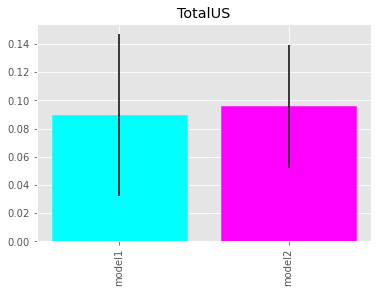

In [56]:
bar = plt.bar([0,1], [np.mean(mae1_test), np.mean(mae2_test)], 
              yerr=[2.95*np.std(mae1_test), 2.95*np.std(mae2_test)])
plt.xticks([0,1], ['model1','model2'], rotation=90)
bar[0].set_color('cyan'), bar[1].set_color('magenta')
plt.title('TotalUS')

# UNSEEN DATA PREDICTION

# FUNCTION FOR STOCHASTIC DROPOUT FOR UNSEEN COUNTY

In [57]:
def test_other_drop1(typ, enc, NN):
    
    if typ == 'conventional':
        X = np.concatenate([X_other_train_c, X_other_test_c],axis=0)
        F = np.concatenate([f_other_train_c, f_other_test_c],axis=0)
        y = np.concatenate([y_other_train_c, y_other_test_c],axis=0)
    elif typ == 'organic':
        X = np.concatenate([X_other_train_o, X_other_test_o],axis=0)
        F = np.concatenate([f_other_train_o, f_other_test_o],axis=0)
        y = np.concatenate([y_other_train_o, y_other_test_o],axis=0)
    
    enc_pred = enc.predict(X)
    enc_pred = np.concatenate([enc_pred, F], axis=2)
    trans_pred = scaler1.transform(enc_pred.reshape(-1,enc_pred.shape[-1])).reshape(-1,sequence_length,enc_pred.shape[-1])
    NN_pred = NN.predict(trans_pred)
    
    return NN_pred, y


def test_other_drop2(typ, NN):

    if typ == 'conventional':
        X = np.concatenate([X_other_train_c, X_other_test_c],axis=0)
        F = np.concatenate([f_other_train_c, f_other_test_c],axis=0)
        y = np.concatenate([y_other_train_c, y_other_test_c],axis=0)
    elif typ == 'organic':
        X = np.concatenate([X_other_train_o, X_other_test_o],axis=0)
        F = np.concatenate([f_other_train_o, f_other_test_o],axis=0)
        y = np.concatenate([y_other_train_o, y_other_test_o],axis=0)
    
    XF = np.concatenate([X,F], axis=2)
    trans_pred = scaler2.transform(XF.reshape(-1,XF.shape[-1])).reshape(-1,sequence_length,XF.shape[-1])
    NN_pred = NN.predict(trans_pred)
    
    return NN_pred, y

In [ ]:
# COMPUTE STOCHASTIC DROPOUT FOR UNSEEN COUNTY

In [ ]:
mae1_other, p1_other = [], []

for i in tqdm.tqdm(range(0,100)):
    pred1_other, true1_other = test_other_drop1('organic', encoder, model1)
    mae1_other.append(mean_absolute_error(true1_other, pred1_other))
    p1_other.append(pred1_other)

print(np.mean(mae1_other), np.std(mae1_other))

In [ ]:
# COMPUTE STOCHASTIC DROPOUT FOR UNSEEN COUNTY

In [ ]:
mae2_other, p2_other = [], []

for i in tqdm.tqdm(range(0,100)):
    pred2_other, true2_other = test_other_drop2('organic', model2)
    mae2_other.append(mean_absolute_error(true2_other, pred2_other))
    p2_other.append(pred2_other)

print(np.mean(mae2_other), np.std(mae2_other))

In [ ]:
# PLOT AVG AND UNCERTAINTY OF RESULTS

In [ ]:
bar = plt.bar([0,1], [np.mean(mae1_other), np.mean(mae2_other)], 
              yerr=[2.95*np.std(mae1_other), 2.95*np.std(mae2_other)])
plt.xticks([0,1], ['model1','model2'], rotation=90)
bar[0].set_color('cyan'), bar[1].set_color('magenta')
plt.title('ORGANIC Albany')